In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from datetime import datetime
sns.set()

<a id='EDA'></a>

# COVID19 Exploratory Data Analysis

# Exploratory Data Analysis

<a id='toc'></a>

# Table of contents

### [1. Introduction](#intro)

### [2. Function declarations](#func)

### [3. General COVID19 exploration](#explore)

### [4. Data quality exploration](#quality)
    
### [5. The effect of government reaction times](#reaction)

### [6. Government stringency index vs. growth factors](#gfactor)
    
### [7. Two-way ANOVA: countries, stringency subcomponents and growth factors](#ANOVA)

### [8. Dependent variable preview](#dependent)

### [9. Summary](#summary)

<a id='intro'></a>
# 1. Introduction
This notebook uses a variety of different COVID-19 related datasets to explore the behavior
of the multiple time series'. This notebook also creates new features that attempt to encapsulate the
time dependent (and time delayed) nature of the problem; these will be used during the model creation
project which makes time dependent forecasting models. 

There are a number of specific investigations that are relevant to the current situation as of July 7th 2020, even though data is only through June 30th.
The other category of investigations are regarding the data which will be used in the regression and neural network
models. 


<a id='func'></a>
# 2. Function declarations

In [2]:
def column_search(df, name, return_style='loc', threshold='contains'):
    # Lots of column originally, instead of memorizing I just created a helper
    # function to help search. 
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def intersect_indexes(df1,df2,level=0):
    # If an intersection of values (typically countries or dates) is desired.
    intersection = df1.index.get_level_values(level).intersection(df2.index.get_level_values(level))
    return df1.loc[intersection], df2.loc[intersection]


def country_slice(data, locations):
    # slice out single or multiple locations. 
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    # Slice out different time ranges. 
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True,figsize=(4,4),xaxis='date'):
    # This produces time plots for countries separately such that they share the x-axis
    # and the x-axis can be easily changed. 
    data.set_index([xaxis, 'location']).loc[:, feature].unstack().plot(figsize=figsize, legend=legend)
    return None

def rolling_features(df, features, roll_widths):
    # Helper function which returns a DataFrame of rolling standard deviation and means
    # for the desired features.
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = (df.loc[:,features].fillna(value=0.)
                   ).groupby(df.location).rolling(window).mean().fillna(value=0.)
        rollstd = (df.loc[:,features].fillna(value=0.)
                   ).groupby(df.location).rolling(window).std().fillna(value=0.)

        new_features = pd.concat((rollmean, rollstd), axis=1)
        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list, axis=1)

def compare_ma_std_series(data, feature_names, location_list, scale=None, figname=None, xaxis='date'):
    # Produce a MA +- standard deviation plot for various features and locations. 
    fig, ax = plt.subplots(figsize=(10,5))
    roll_mean_name, roll_std_name = feature_names

    roll_width = [char for char in roll_mean_name][-1]
    feature = roll_mean_name.split('_rolling')[0]
    data_plot = data.copy().set_index(xaxis)
    label_increment =(data.time_index.max()-data.time_index.min())//5
    for location in location_list:
        location_df = data_plot[data_plot.location==location]
        rollmean = location_df.loc[:, roll_mean_name].values
        rollstd = location_df.loc[:, roll_std_name].values
        lower = rollmean - rollstd
        lower[lower<0] = 0
        upper = rollmean + rollstd
        cis = (lower, upper)
        ax.fill_between(range(len(location_df)), cis[0], cis[1], alpha=0.1)
        ax.plot(range(len(location_df)), rollmean,
                        label=location)
        plt.title((feature+' {}-day MA +- {}-day STD ').format(roll_width,roll_width))
        _ = ax.set_ylabel(feature)
        _ = ax.set_xlabel(xaxis.capitalize())
        _ = ax.set_xticks(range(0,len(location_df),label_increment))
        if xaxis=='date':
            _ = ax.set_xticklabels(location_df.index[::label_increment].date)
        else:
            _ = ax.set_xticklabels(location_df.index[::label_increment])
        ax.grid(True)
    plt.legend(loc='upper left')
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
    if scale == 'log':
        ax.set_yscale('log')
    _ = plt.show()

    
    return None

def modify_time_series_zeros(df, feature):
    # This is a function whose purpose is to fix "errant" zeros which occur
    # as gaps in the reported numbers, typically for tests. The assumption here
    # is that tests occur every day but reporting does not, necessarily. 
    df_modified = data.copy()
    fix_ind = df_modified.index[df_modified.loc[:, feature] < 0]
    df_modified.loc[fix_ind, feature] = 0
    df_modified.loc[:, feature] = \
    (df_modified.loc[:, feature].replace(to_replace=0., value=np.nan)
    ).groupby(data.location).fillna(method='ffill').fillna(value=0)
    return df_modified

<a id='explore'></a>
# 3. General Exploration
[Return to table of contents](#toc)

The first thing to do is to first import and wrangle some values if only to be better suited for plots. Also, remove the "World" location; if I want a global average I shall simply do it myself.

In [3]:
# Read in the data
data = pd.read_csv('data.csv', index_col=0)
# If I want a global aggregate, do it manually as "World" is specific to 1 dataset
# This allows the location feature to only contain country names.
data = data[data.location!='World']

# If missing values, fill with 0 (this notebook is set up to be used after cleaning and so this
# should not actually do anything). 
data.loc[:,data.select_dtypes(include='number').columns] = data.select_dtypes(include='number').fillna(0)

# Time index is stored as started from 0, but makes more sense to start from 1 in plots, in my opinion
data.loc[:, 'time_index'] += 1
data.loc[:, 'time_index'] = data.loc[:,'time_index'].astype(int)
# convert object imported datetime to datetime. 
data.loc[:, 'date'] = pd.to_datetime(data.date).dt.normalize().values

The most sensible start to my exploration was to get a sense of the current status of the pandemic worldwide. To do so, I look at the difference in 30 day averages of new cases for each country to see if they have postive, flat, and negative growth rates. 

In [4]:
two_months_ago = time_slice(data, -60, -30)
last_month = time_slice(data, -30, -1)

last_month_new_cases = (last_month[last_month.date == last_month.date.max()].total_cases.reset_index(drop=True) 
- last_month[last_month.date == last_month.date.min()].total_cases.reset_index(drop=True))

two_months_ago_new_cases = (two_months_ago[two_months_ago.date == two_months_ago.date.max()].total_cases.reset_index(drop=True) 
- two_months_ago[two_months_ago.date == two_months_ago.date.min()].total_cases.reset_index(drop=True))

# rate of change of new cases per month  
thirty_day_rate_of_change = last_month_new_cases - two_months_ago_new_cases
# round down small changes to 0. 
thirty_day_rate_of_change[np.abs(thirty_day_rate_of_change)<10] = 0

positive_growth = 100 * (thirty_day_rate_of_change > 0).sum() / len(thirty_day_rate_of_change)
negative_growth =100 * (thirty_day_rate_of_change < 0).sum() / len(thirty_day_rate_of_change)
stationary_growth = 100 * (thirty_day_rate_of_change==0).sum() / len(thirty_day_rate_of_change)
print('Today, %.2f percent of countries have a positive 30-day growth rate' % positive_growth)
print('Today, %.2f percent of countries have a negative 30-day growth rate' % negative_growth)
print('Today, %.2f percent of countries have approximately stationary 30-day growth rate' % stationary_growth)

Today, 53.63 percent of countries have a positive 30-day growth rate
Today, 29.76 percent of countries have a negative 30-day growth rate
Today, 16.61 percent of countries have approximately stationary 30-day growth rate


It seems that for the majority of countries, the situation is worsening. To see how we got to the point, let's look at the history of the pandemic using summary statistics of the "age" of the pandemic in each country. These are calculated using the ```days_since_first_case``` feature column which is a linearly growing time index which has repeated 0's until the confirmation of the first case: i.e., typically it looks like this: ```[0, 0, 0, 0, ..., 0, 1, 2, 3, 4, ...]```

In [5]:
today = time_slice(data,-1,-1)
print('The statistics of the age of the pandemic in each country, in units of days.\n')
print(today.days_since_first_case.describe())

The statistics of the age of the pandemic in each country, in units of days.

count    289.000000
mean     115.564014
std       19.247390
min       27.000000
25%      105.000000
50%      113.000000
75%      122.000000
max      160.000000
Name: days_since_first_case, dtype: float64


The minimum in this case shows that there is a country whose exposure was determined only 27 days ago. Meaning that the pandemic may or may not have even spanned the range of its potential spread geographically.
To get an idea as to the spread of COVID-19, look at the distribution of the first recorded cases, deaths, and tests of all locations. 

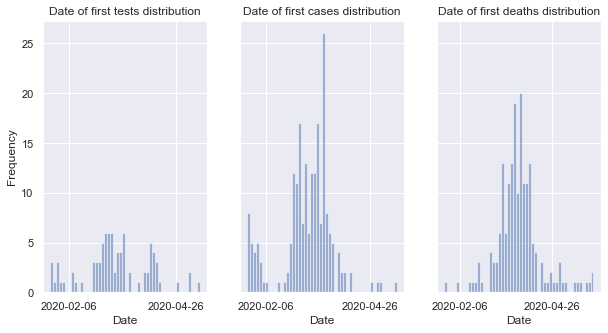

In [6]:
labelstart = 15
label_increment = (data.time_index.max() - data.time_index.min())//2

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5), sharey=True)
first_dates_temp = data.replace(to_replace=0., value=np.nan)
first_tests = data.loc[first_dates_temp.total_tests_owid.dropna().index,:].groupby('location').time_index.min()
first_cases =  data.loc[first_dates_temp.total_cases_owid.dropna().index,:].groupby('location').time_index.min()
first_deaths = data.loc[first_dates_temp.total_deaths_owid.dropna().index,:].groupby('location').time_index.min()
first_tests.plot.hist(alpha=0.5, bins=50, ax=ax1)
first_cases.plot.hist(alpha=0.5, bins=50, ax=ax2)
first_deaths.plot.hist(alpha=0.5, bins=50, ax=ax3)

_ = ax1.set_xlabel('Date')
_ = ax1.set_title('Date of first tests distribution')
_ = ax1.set_xticks(range(labelstart,data.time_index.max(),label_increment))
_ = ax1.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

_ = ax2.set_xlabel('Date')
_ = ax2.set_title('Date of first cases distribution')
_ = ax2.set_xticks(range(labelstart,data.time_index.max(),label_increment))
_ = ax2.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])

_ = ax3.set_xlabel('Date')
_ = ax3.set_title('Date of first deaths distribution')
_ = ax3.set_xticks(range(labelstart, data.time_index.max(),label_increment))
_ = ax3.set_xticklabels(data.date.dt.date.unique()[labelstart::label_increment])
plt.savefig('distribution_of_first_events.jpg', bbox_inches='tight')

Just an idea to keep in mind, as the beginning of each pandemic is unlike the period of time where it is full blown. The middle of the date range corresponds to the month of March, indicating that most countries experienced their first (recorded) cases around that month. In the modeling process, one thing that can be tested to possibly increase model performance is to include the time indices for which most countries have cases, in the figure below this would be approximately the beginning of April 2020. 

#### Time series visualization

The previous calculations gave us an idea into the instantaneous state of the pandemic, but let's investigate the time dependence by looking at the countries with highest numbers of cases and deaths, see if these countries are indeed testing sufficiently (i.e. the countries with highest tests would hopefully be the same). The following is an attempt to support my choices for which source to use for case and testing data. First, the testing data, the OWID dataset has a propensity to not have values for the most recent dates for testing. I.e. the new tests per million would be zero for the most recent days. Unsure why this is but I believe its a reporting issue and not an including the union of all dates issue. To get a feel for the current countries which are impacted the most, look at the most recent values for cases, tests, and deaths per million. One thing to note is that if a country has a high new case count and low testing, the situation may be far worse than it seems.

The top ten countries in terms of confirmed total cases.

In [7]:
today.loc[:, ['location', 'total_cases_owid']].sort_values(by='total_cases_owid').dropna()[-10:][::-1]

,location,total_cases_owid
43469,United States,2590552.0
5151,Brazil,1368195.0
34775,Russia,641156.0
18031,India,566840.0
43147,United Kingdom,311965.0
33004,Peru,282365.0
7727,Chile,275999.0
38639,Spain,249271.0
19802,Italy,240436.0
18836,Iran,225205.0


Likewise, for deaths

In [8]:
today.loc[:, ['location', 'total_deaths_owid']].sort_values(by='total_deaths_owid').dropna()[-10:][::-1]

,location,total_deaths_owid
43469,United States,126140.0
5151,Brazil,58314.0
43147,United Kingdom,43575.0
19802,Italy,34744.0
13684,France,29813.0
38639,Spain,28355.0
25920,Mexico,27121.0
18031,India,16893.0
18836,Iran,10670.0
3702,Belgium,9752.0


In [9]:
top_10_locations_most_cases = today.set_index('location').new_cases_owid.dropna().sort_values()[-10:].index
top_10_locations_most_tests = today.set_index('location').new_tests_testtracker.dropna().sort_values()[-10:].index
top_10_locations_most_deaths = today.set_index('location').new_deaths_owid.dropna().sort_values()[-10:].index

Let's visualize this to be more insightful.
Plot the recent values of the time series for the countries in the top 10 for new cases, tests, deaths.

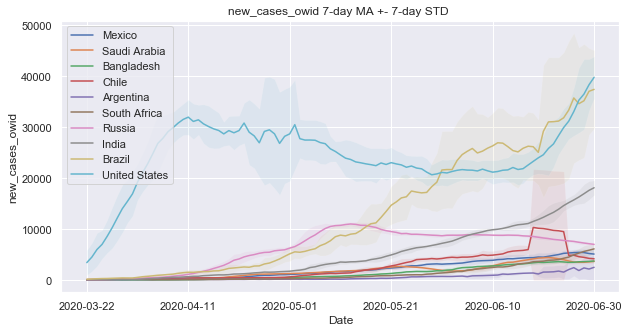

In [10]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_cases_owid_rolling_mean_7','new_cases_owid_rolling_std_7'), 
                      top_10_locations_most_cases,figname='top_10_new_cases.jpg')

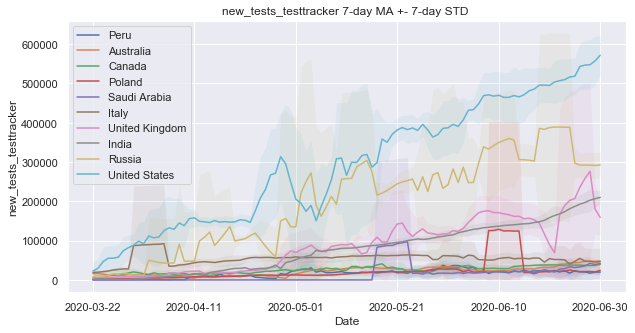

In [11]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_tests_testtracker_rolling_mean_7','new_tests_testtracker_rolling_std_7'), 
                      top_10_locations_most_tests)

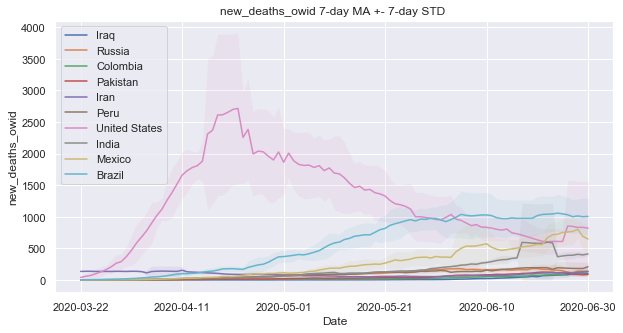

In [12]:
compare_ma_std_series(time_slice(data,-100,-1),
                      ('new_deaths_owid_rolling_mean_7','new_deaths_owid_rolling_std_7'), 
                      top_10_locations_most_deaths,figname='top_10_new_deaths.jpg')

The countries which are in the top 10 cases but are not in the top ten of tests are probably not testing enough; this should probably be calculated in another way, such as a case-test ratio. 

In [13]:
print('The countries that should test more are:')
print(top_10_locations_most_cases[~top_10_locations_most_cases.isin(top_10_locations_most_tests)].tolist())

The countries that should test more are:
['Mexico', 'Bangladesh', 'Chile', 'Argentina', 'South Africa', 'Brazil']


These regressions show that there is evidence for a statistically significant relationship between the average stringency and the approximate growth rates but not the maximum stringency. This makes sense, due to the time-delayed nature of the disease. I.e. if you're really strict but only for a single day/week then it wouldn't slow down the infection. 

### Data exploration specific to the United States.
[Return to table of contents](#toc)

The situation in the U.S. is quickly deteriorating, to the point where there needs to be more investigation into why this happened and the specifics for each state in order to forecast. Look at some time series plots for the states with the 10 most number of new cases.

In [14]:
states = pd.read_csv('jhucsse_usa.csv').location.unique()
usa_data = data[data.location.isin(states.tolist())].set_index(['time_index','location'])
usa_data.loc[:, 'new_cases_jhucsse_usa'] = usa_data.groupby(level=1).cases_jhucsse_usa.diff(1).fillna(0).values
usa_data.loc[:, 'new_deaths_jhucsse_usa'] = usa_data.groupby(level=1).deaths_jhucsse_usa.diff(1).fillna(0).values
usa_data = usa_data.reset_index()

In [15]:
ten_states_with_most_new_cases = time_slice(usa_data,-1,-1).set_index('location').new_cases_jhucsse_usa.sort_values()[-10:].index

Because I decided to work with a separate dataset only using the states of the United States, need to recompute the moving averages

In [16]:
new_features = rolling_features(usa_data, ['new_cases_jhucsse_usa','new_deaths_jhucsse_usa'], [3]).reset_index(drop=True)
usa_data = pd.concat((usa_data, new_features),axis=1)
# usa_data = usa_data.reset_index()

In the past 40 days or so, the infections have spread dramatically in a few states. Check the trends of the 10 worst states by plotting rolling average.

In [17]:
feature_names = ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3')
location_list = ten_states_with_most_new_cases.tolist()

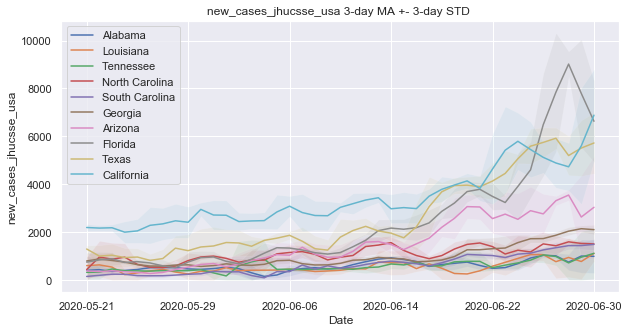

In [18]:
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      ('new_cases_jhucsse_usa_rolling_mean_3','new_cases_jhucsse_usa_rolling_std_3'), 
                      ten_states_with_most_new_cases.tolist(),figname='top_10_new_cases_america.jpg')


The number of cases seem to be increasing dramatically; this can have devastating consequences so let's also plot the deaths.

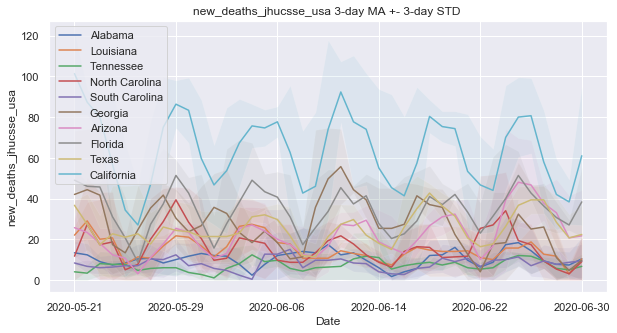

In [19]:
compare_ma_std_series(usa_data[usa_data.time_index>120],
                      ('new_deaths_jhucsse_usa_rolling_mean_3','new_deaths_jhucsse_usa_rolling_std_3'), 
                      ten_states_with_most_new_cases.tolist(),figname='top_10_new_deaths_america.jpg')


At least the number of deaths seems to be maintaining the same, seasonal behavior. If I was unaware and I saw this I would assume that hospitals have not been overwhelmed yet, which is currently still the case. This would require looking at the hospitalization data. If hospitals are becoming overwhelmed then perhaps one explanation would be medical professionals are getting better at treating the illness.

<a id='quality'></a>
# 4. Data quality
[Return to table of contents](#toc)

It is important for modeling purposes to determine whether or not the data is represented correctly and is "clean" so that
any forecasting results are valid.
In order to know whether or not there is any funny business going on, I look at the main time series variables and their differences between data sets. First, I look at three different manners of computing the number of new cases per day (global sum). The blue and orange curves come from two separate data sets as is, and the 'total_cases_diff' curve is calculated by taking the 1-day finite difference of the cumulative cases variable, which itself is an average of all total cases variables in the data cleaning notebook. 

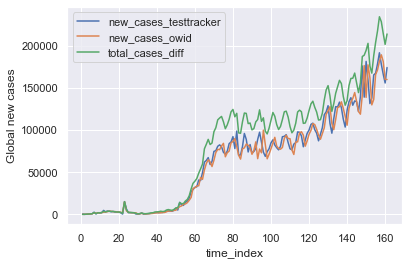

In [20]:
data.loc[:, column_search(data,'new_cases')[:2].tolist()+['location','time_index']].groupby('time_index').sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_cases.diff(1).fillna(0)
).plot(legend=True, label='total_cases_diff')
_ = plt.ylabel('Global new cases')
plt.savefig('cases_different_datasets.jpg', bbox_inches='tight')

Next is a demonstration as to why certain features had to be manipulated and have their values changed; strangeness in reporting. First, I'll demonstrate some peculiarity in the reporting of testing data.

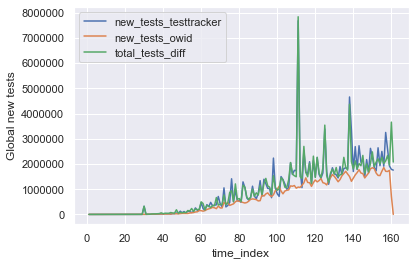

In [21]:
data.loc[:, column_search(data,'new_tests')[:2]].groupby(data.time_index).sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_tests.diff(1).fillna(0)
).plot(legend=True, label='total_tests_diff')
_ = plt.ylabel('Global new tests')
plt.savefig('tests_different_datasets.jpg', bbox_inches='tight')

For believed reporting reasons, the new tests from the OWID data are all zero for the most recent date. This is what the features look like once the time series have been modified.

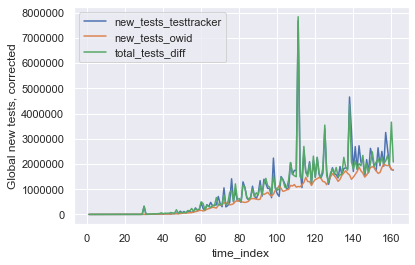

In [22]:
data = modify_time_series_zeros(data, 'new_tests_owid')
data.loc[:, column_search(data,'new_tests')[:2]].groupby(data.time_index).sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_tests.diff(1).fillna(0)
).plot(legend=True, label='total_tests_diff')
_ = plt.ylabel('Global new tests, corrected')
plt.savefig('tests_different_datasets_corrected.jpg', bbox_inches='tight')

The next figure is an exmple between the total deaths (which is the feature that I engineered which aggregated the different reports of deaths. By taking the total deaths and then the single day finite difference I can create a time series which is supposed to reproduce the original new deaths feature.

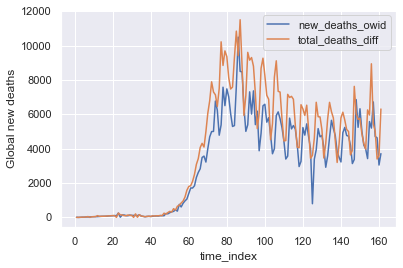

In [23]:
data.loc[:, column_search(data,'new_deaths')[:1].tolist()+['location','time_index']].groupby('time_index').sum().plot()
(data.set_index(['time_index','location']).groupby(level=0).sum().total_deaths.diff(1).fillna(0)
).plot(legend=True, label='total_deaths_diff')
_ = plt.ylabel('Global new deaths')
plt.savefig('deaths_different_datasets.jpg', bbox_inches='tight')

Next is the demonstration for my reasoning for why locations under 1 million in population are removed from the dataset.
The idea is that due to their small populations, the weighted quantity, new cases per million people, is unusually large in
magnitude. In fact, if I find the maximum for every country, and then plot the 20 countries with the largest maxima, this is what I get. 

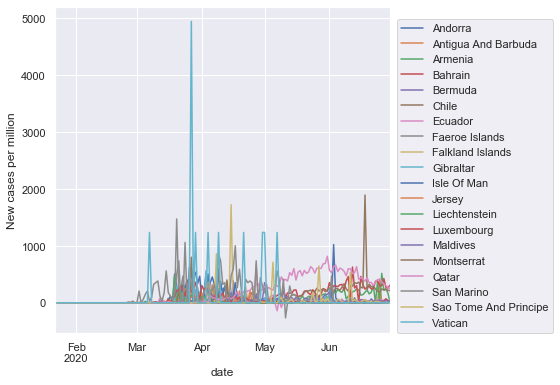

In [24]:
twentiest_largest_ncpm = data.groupby('location').max().new_cases_per_million_owid.sort_values()[-20:].index
per_country_plot(country_slice(data, twentiest_largest_ncpm), 'new_cases_per_million_owid', figsize=(6,6))
plt.ylabel('New cases per million')
plt.legend(loc=(1.02,0.))
plt.savefig('top_20_largest_new_cases.jpg', bbox_inches='tight')

In [25]:
print(('The countries with 20 largest new cases per million value account '
       'for only {} million people in the world').format(
    int(country_slice(data, twentiest_largest_ncpm).population_owid.unique().sum())//1000000))

The countries with 20 largest new cases per million value account for only 46 million people in the world


There is also an argument to be made to not use the testing data at all, largely because it is inconsistent in that
it contains a lot of reporting errors and is susceptible to very pathological time series; not only that, but also
the units for countries reporting testing differ. Some countries report the total number of tests completed while others
report the number of people tested. For instance, look at the difference in the time series for the 5 countries between different data sets.

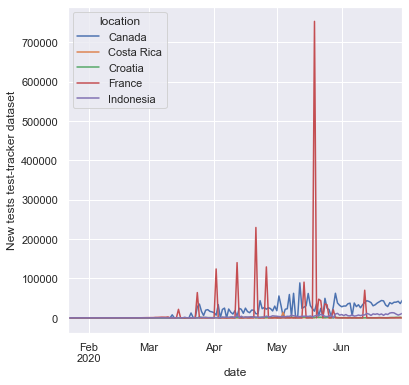

In [26]:
data.tests_units_owid.value_counts()
tests_units_are_people_tested = data[data.tests_units_owid=='people tested']
top5_people_tested = tests_units_are_people_tested.location.unique()[:5]

per_country_plot(country_slice(data, top5_people_tested), 'new_tests_testtracker',figsize=(6,6))
plt.ylabel('New tests test-tracker dataset')
plt.savefig('top5_people_tested.jpg', bbox_inches='tight')

Theoretically, the OWID dataset shouuld have the same units; plot to see if this is true.

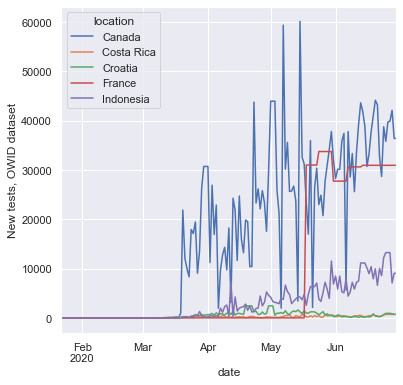

In [27]:
per_country_plot(country_slice(data, top5_people_tested), 'new_tests_owid', figsize=(6,6))
plt.ylabel('New tests, OWID dataset')
plt.savefig('top5_new_tests.jpg', bbox_inches='tight')

As can be seen by the large discrepancy by the time series, there are inconsistencies between reported testing numbers.

#### Exploration into stringency (quarantine measures)

Using Italy and America as two example countries, we can display two dramatically different time series. 
Although Italy had a similar number of cases per million as the United States (and earlier on, when less information on the disease was out), their reaction and subsequent actions seem to have quelled the pandemic, when measured by the current number of new cases per million people. As can be seen in the figure below, the United States followed a similar pattern in the begin of its pandemic, but the did not have the same result as Italy. 

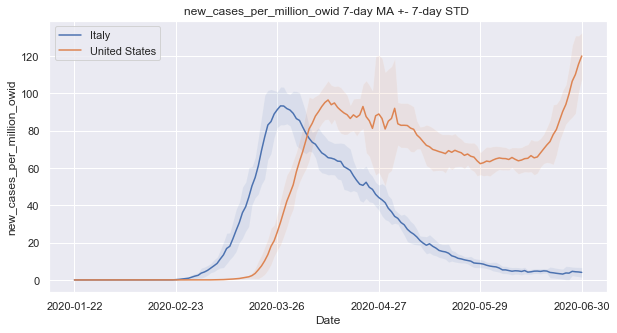

In [28]:
names = ('new_cases_per_million_owid_rolling_mean_7', 'new_cases_per_million_owid_rolling_std_7')
compare_ma_std_series(data, names, [ 'Italy','United States'], figname='ITA_vs_USA.jpg')

To analyze what was done differently, I look towards Blavatnik's school of governments' (University of Oxford) stringency index, which quantifies the government strictness of each country. The Italian government was much more strict when their cases per million was peaking, which allowed for them to loosen restrictions sooner, once the pandemic was under control. I investigate later on the relation between this stringency index and other important quantities.

location
Italy            62.106894
United States    50.497640
dtype: float64


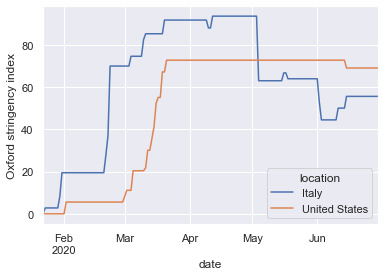

In [29]:
ITA_USA_stringency = data[data.location.isin( ['United States', 'Italy'])].set_index(['date','location']).stringency_index_oxcgrt.unstack()
ITA_USA_stringency.plot()
print(ITA_USA_stringency.mean())
_ = plt.ylabel('Oxford stringency index')
_ = plt.savefig('ITA_vs_USA_stringency.jpg', bbox_inches='tight')

<a id='reaction'></a>
# 5. Government reaction times
[Return to table of contents](#toc)

The next segment of exploration is into the statistical significance of different quarantine measures on the number of new cases. This is a crude approximation and likely should not be treated as an official result. First, however, let's explore the timelines and values of different governments' reactions. The first step is to collect all of the reactions into a dataframe.

In [30]:
government_responses = pd.concat((data.loc[:, ['location','time_index','days_since_first_case']],
                                  data.loc[:, column_search(data, 'oxcgrt')].drop(
                                      columns=column_search(data, 'flag')).iloc[:,2:10]), axis=1)

Find the countries which eventually have all responses by a conditional statement which counts if a country only
has 0 as a value for any specific measure. In other words, if the value for a mandate is always 0, that means it was never
enacted. 

In [31]:
countries_with_responses = government_responses.groupby('location').max().dropna()
countries_with_all_responses = (countries_with_responses.iloc[np.where((
    government_responses.groupby('location').max().dropna()==0).sum(1)==0)[0],:])


In [32]:
tmptmp = (government_responses[~government_responses.isin(states)].groupby('location').max()==0).sum(axis=1)
government_responses_all = government_responses[government_responses.location.isin(tmptmp.index[tmptmp==0])].set_index('location')

With the list of applicable countries, can now begin to acquire the dates on which each mandate started (and ended).

In [33]:
# responses = pd.Index(['active_pandemic_dates']).append(countries_with_all_responses.columns[2:])
responses = pd.Index(['active_pandemic_dates']).append(government_responses_all.columns[2:])

# all_responses = government_responses[government_responses.location.isin(countries_with_all_responses.index)]
all_responses = government_responses_all.reset_index()
response_ranges = []
for c in all_responses.columns[2:]:
    active_range = (all_responses.loc[:, ['time_index','location']+[c]].replace(to_replace=[0,0.], value=np.nan)
                   ).dropna().groupby('location').time_index
    response_ranges.append([slice(*x) for x in list(zip(active_range.min().values, active_range.max().values+1))])
    

response_slices_df = pd.DataFrame(np.array(response_ranges).transpose(),
                                 index=all_responses.location.unique(), columns=responses)

Next, using an average of the enaction dates of the different mandates, let's see how countries reacted, either proactively (average is before first case) or reactively. 

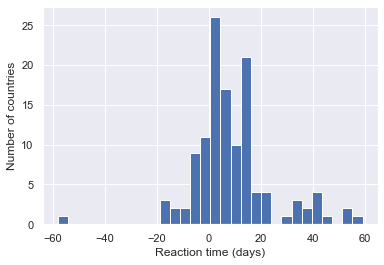

In [34]:
average_response_date = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].mean(1)
average_reaction_times = (average_response_date.astype(int) 
                          - response_slices_df.applymap(lambda x : x.start).active_pandemic_dates)
_ = plt.hist(average_reaction_times, bins=30)
_ = plt.ylabel('Number of countries')
_ = plt.xlabel('Reaction time (days)')
plt.savefig('average_reaction_times_distribution.jpg', bbox_inches='tight')

In [35]:
date_of_first_response = response_slices_df.applymap(lambda x : x.start).iloc[:, 1:].min(1)
date_of_pandemic_start =  response_slices_df.applymap(lambda x : x.start).active_pandemic_dates
minimum_reaction_times = (date_of_first_response-date_of_pandemic_start)

For those curious, I print the list of countries for each reaction speed.
Early responders, first government action BEFORE first case.

In [36]:
early_responders = average_reaction_times[average_reaction_times<0].index.tolist()
print('\n The early responders:\n')
for i in range(len(early_responders)//5+1):
    print(early_responders[5*i:5*(i+1)])


 The early responders:

['Albania', 'Angola', 'Botswana', 'El Salvador', 'Eswatini']
['Fiji', 'Greenland', 'Guatemala', 'Haiti', 'Kenya']
['Kosovo', 'Kyrgyz Republic', 'Laos', 'Lesotho', 'Libya']
['Madagascar', 'Mongolia', 'Myanmar', 'Papua New Guinea', 'Rwanda']
['Sierra Leone', 'South Sudan', 'Syria', 'Uganda', 'Zimbabwe']
[]


Late responders, first government action AFTER first case.


In [37]:
late_responders = average_reaction_times[average_reaction_times>=0].index.tolist()
print('The late responders:\n')
for i in range(len(late_responders)//5+1):
    print(late_responders[5*i:5*(i+1)])

The late responders:

['Afghanistan', 'Algeria', 'Argentina', 'Austria', 'Azerbaijan']
['Bahrain', 'Bangladesh', 'Barbados', 'Belize', 'Bermuda']
['Bhutan', 'Bolivia', 'Bosnia And Herzegovina', 'Brazil', 'Burkina Faso']
['Cape Verde', 'Chad', 'China', 'Colombia', 'Congo']
['Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Democratic Republic Of Congo']
['Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt']
['Eritrea', 'Ethiopia', 'France', 'Gabon', 'Gambia']
['Ghana', 'Greece', 'Guinea Bissau', 'Guyana', 'Honduras']
['Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland']
['Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Jordan']
['Kazakhstan', 'Kuwait', 'Lebanon', 'Liberia', 'Lithuania']
['Mauritius', 'Mexico', 'Moldova', 'Morocco', 'Mozambique']
['Nepal', 'Netherlands', 'New Zealand', 'Nigeria', 'Oman']
['Pakistan', 'Palestine', 'Panama', 'Paraguay', 'Peru']
['Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania']
['Russia', 'San Marino', 'Saudi Arabia', 'Serbia', 'Seychelles']
['Sing

We can see that the majority of countries were reactive instead of proactive. 
A question to be answered, do these average reaction times have a quantifiable effect on serious quantities such as death rate? To investigate, configure the data to be used in regression. Let's see if this reaction time is related to the quantity which I believe best classifies the damage done by the pandemic, which is deaths. Specifically, I'll look at the relationship with death rate.

In [38]:
# death rates
death_rates = today.total_deaths / today.total_cases
death_rates.index = today.location.values

# for regression drop missing values
death_rates = death_rates.dropna()
average_reaction_times = average_reaction_times.dropna()

# These two DataFrames could have dropped different countries, intersect the sets of countries.
countries_with_all_average_reaction = average_reaction_times.index.intersection(death_rates.index)
death_rates = 100*death_rates.loc[countries_with_all_average_reaction]
average_reaction_times = average_reaction_times.loc[countries_with_all_average_reaction]

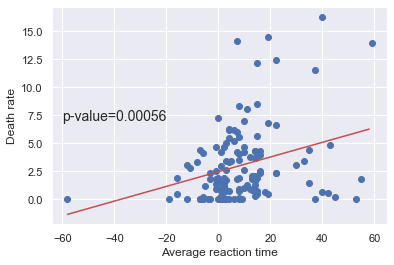

In [39]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(average_reaction_times.values, death_rates.values)

fig, ax = plt.subplots()
ax.scatter(average_reaction_times, 
            death_rates)
ax.plot(np.arange(average_reaction_times.values.min(),average_reaction_times.values.max()),
        slope*np.arange(average_reaction_times.values.min(),average_reaction_times.values.max()) + intercept, color='r')

ax.grid(True)
plt.ylabel('Death rate')
plt.xlabel('Average reaction time')
plt.text(-60.0, 7,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('death_rates_vs_average_reaction_time.jpg', bbox_inches='tight')

<a id='gfactor'></a>
# 6. The effect of government stringency on the number of new cases.
[Return to table of contents](#toc)

Testing for a relationship between the difference in average new cases. and the OxCGRT stringency index.
While interesting to me, looking at the dependence on reaction time can lead to no actionable recommendations because it is by definition a historical quantity.

What can be done? Because the most prolific contribution to the pandemic is human interaction we need to look at the effect of different social distancing measures.

To get a general idea for the state of the world right now in terms of government mandates, look at the levels of quarantine measures versus global average of new cases.  To investigate the effect of the stringency index on the future number of new cases (per million). I'm going to look at the monthly time scale; specifically I'm going to look at the relationship between the average (and max) stringency index and percentage increase (or decrease) between the average number of new cases two months ago and in the previous month. Yemen has some strange values so discard it for now.

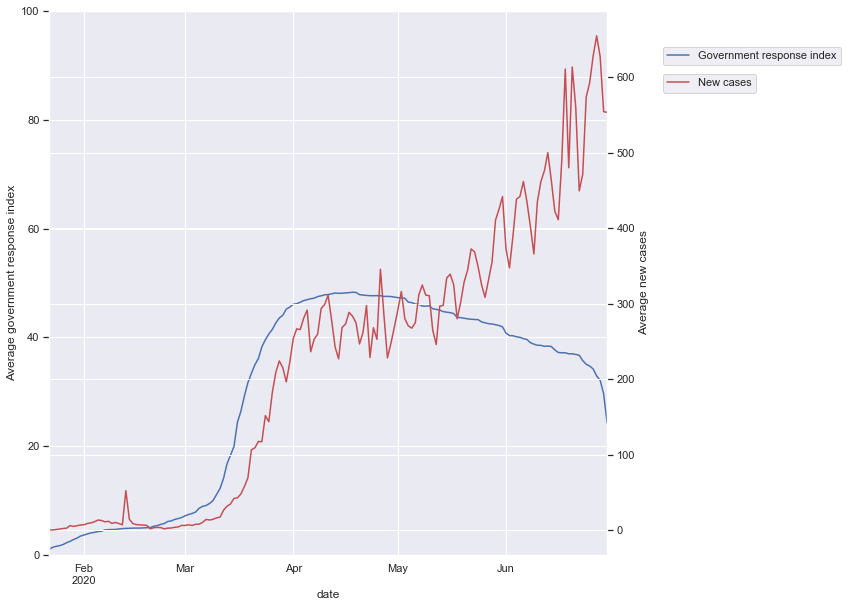

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax2 = ax.twinx()
data.groupby('date').mean().stringency_index_oxcgrt.plot(ax=ax, label='Government response index')
data.groupby('date').new_cases_owid.mean().plot(ax=ax2, color='r', label='New cases')
ax.set_ylim([0,100])
ax.set_ylabel('Average government response index')
ax2.set_ylabel('Average new cases')
ax.legend(loc=(1.1,0.9))
ax2.legend(loc=(1.1,0.85))
plt.savefig('global_average_stringency_vs_cases.jpg', bbox_inches='tight')

Note that the sharp downturn is partly due to errors in reporting, i.e. note the discontinuity at the most recent date for a couple countries.

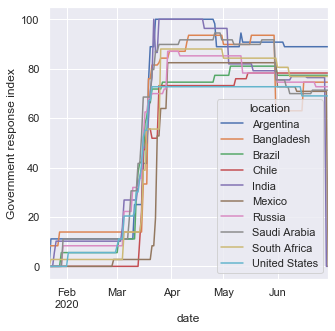

In [41]:
per_country_plot(data[data.location.isin(top_10_locations_most_cases)], 'stringency_index_oxcgrt', figsize=(5,5))
plt.ylabel('Government response index')
plt.savefig('stringency_top_10_countries.jpg', bbox_inches='tight')

In [42]:
locations_with_population_info = data.loc[data.population_owid.dropna().index,:]
locations_with_population_info.loc[:, 'total_cases_per_million'] = \
(locations_with_population_info.total_cases / (locations_with_population_info.population_owid/1000000.))
locations_with_population_info = locations_with_population_info.set_index('location')

Compute the monthly (technically 30-day) averages of the number of new cases per million.

In [43]:
last_month_average_cpm = (time_slice(locations_with_population_info, -30, -1).new_cases_per_million_owid
               .replace(to_replace=np.inf,value=np.nan)
              ).dropna().groupby(level=0).mean().replace(to_replace=0., value=np.nan)

two_months_ago_average_cpm = (time_slice(locations_with_population_info, -60, -30).new_cases_per_million_owid
               .replace(to_replace=np.inf,value=np.nan)
              ).dropna().groupby(level=0).mean().replace(to_replace=0., value=np.nan)

Find the average and maximum stringency index in next to last 30 days.

In [44]:
two_months_ago_stringency= time_slice(locations_with_population_info,-60,-30).stringency_index_oxcgrt
two_months_ago_max_stringency = two_months_ago_stringency.groupby(level=0).max()
two_months_ago_mean_stringency = two_months_ago_stringency.groupby(level=0).mean()

Take only the countries which have non-zero stringency values (data set countries USA states, OxCGRT stringency index does not report these locations).

If there is growth, then let that be positive, i.e. let last month > two months be positive.

In [45]:
case_average_difference = (two_months_ago_average_cpm-last_month_average_cpm)

In [46]:
locations_with_stringency_data = two_months_ago_max_stringency.replace(to_replace=0., value=np.nan).dropna().index
location_intersection = case_average_difference.index.intersection(locations_with_stringency_data)

My claim is that the number of new cases per million affects the next month stringency, which affects next month change in cases. Look at the multiplicative growth factor because absolute number of new cases will depend on how many cases total. 

0.40675521657227576


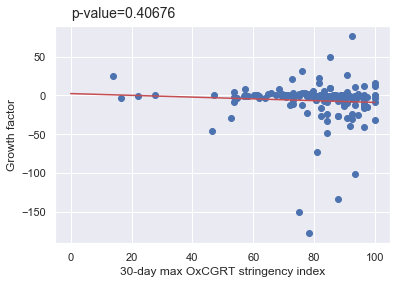

In [47]:
x = two_months_ago_max_stringency.loc[location_intersection]
y = case_average_difference
x, y =   intersect_indexes(x.dropna(), y.dropna(), level=0)
x, y = x.values, y.values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.grid(True)
print(p_value)
plt.ylabel('Growth factor')
plt.xlabel('30-day max OxCGRT stringency index')
plt.text(0.0, 100,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('case_average_difference_vs_max_stringency.jpg', bbox_inches='tight')

0.036983668734356906


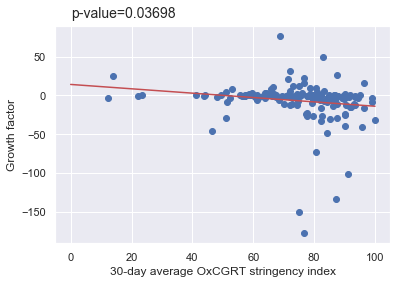

In [48]:
x = two_months_ago_mean_stringency.loc[location_intersection]
y = case_average_difference
x, y =   intersect_indexes(x.dropna(), y.dropna(), level=0)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x.values, y.values)

fig, ax = plt.subplots()
ax.scatter(x.values , y.values)
ax.plot(np.arange(0,np.max(x+1)), slope*np.arange(0,np.max(x+1)) + intercept, color='r')
ax.grid(True)
print(p_value)
plt.ylabel('Growth factor')
plt.xlabel('30-day average OxCGRT stringency index')
plt.text(0.0, 100,'p-value='+str(np.round(p_value,5)),fontsize=14)
plt.savefig('case_average_difference_vs_mean_stringency.jpg', bbox_inches='tight')

Upon inspection, while the p-value indicates a statistical significant relationship, however this is a counter intuitive result. Note that more negative values mean that the pandemic has become **worse**. The negative correlation (albeit weak) indicates that the stricter a country becomes the worse the situation gets; now, this is because countries with worse pandemics **must** become more strict, unless they want the situation to spiral out of control. Therefore, the pandemics get worse in spite of the fact that the countries are stricter; I interpret this as even though the countries became more strict, they were likely too late. This univariate analysis tests the average of an index quantity which is itself an average. To get into more detail let's look at the effect of the different subcomponents.

The stringency index is a quantification of the following measures. As there are only 8 entries recorded by OxCGRT, this is likely not an exhaustive list, but rather the most common measures.

 <a id='ANOVA'></a>
## 7. Testing the importance of stringency index subcomponents. 
[Return to table of contents](#toc)

With the world currently under maintenance and public sentiment deteriorating, it is important to identify
the most efficient quarantine measures so that governments know how to be proactive going forward.
The question to answer: Is there a relationship between the growth rate of the number of new cases and different mandate types?

The following list are the 8 specific mandates 

     school closing
     workplace closing
     cancel public events
     restrictions on gatherings
     close public transport
     stay at home requirements
     restrictions on internal movement
     international travel controls
     
I will apply a two-way ANOVA, with a randomized complete block design (the treatments being the mandate, the blocks are the countries) on the difference of two averages. The averages will be the average number of new cases in the 30-day periods before and after the initiation of the mandate. If a country did not enact a mandate, this value is set to 0, instead of dropping the corresponding sample. 
    
#### Acquiring the observations to test with.

To test this relation, I will first engineer a new feature whose purpose is to quantify the effect of the various quarantine measures. This feature is the difference between the 30 day averages of the number of new cases per million people. That is,
compute the dates at which each mandate occurs, calculate the average number of cases per million people in the 30 days before and after this date. Take the ratio to approximate a growth rate in the number of new cases.
The reason why I average over 30 day intervals is to reduce the effect of any outliers and smooth out any erratic reporting behavior. Additionally, there is a (the specifics are still unknown to the broader community) time-delay component to the spread of the infection. 

This requires a few steps:

    2. Find the dates on which each mandate started.
    3. Find the +- 30 day averages and take their difference.
    4. Format the data in a way to be compatible with statsmodels api, which will be used for the ANOVA.
    5. Look at the p-values for the blocks (countries) and treatments (mandates).
    
There are also a number of assumptions for the ANOVA I am using and the linear model therein, such as equal variances, normally distributed residuals, independent observations. The biggest argument against the validity of any results is the fact that these mandates overlap with respect to time, and hence may not be completely independent. 

In [49]:
government_responses_labels =['school closing',
 'workplace closing',
 'cancel public events',
 'restrictions on gatherings',
 'close public transport',
 'stay at home requirements',
 'restrictions on internal movement',
 'international travel controls']

In [50]:
start_dates = response_slices_df.applymap(lambda x : x.start)
stop_dates = response_slices_df.applymap(lambda x : x.stop)
start_dates.columns =[x[0] for x in response_slices_df.columns.str.split('_oxcgrt')]

These values are in terms of the integer time index, not the datetime values. 

In [51]:
start_dates = start_dates.dropna().astype(int).iloc[:,1:]
start_dates.sample(5)

,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,c5_close_public_transport,c6_stay_at_home_requirements,c7_restrictions_on_internal_movement,c8_international_travel_controls
Croatia,52,53,49,59,60,62,62,14
Eritrea,66,70,62,62,62,62,55,50
Rwanda,55,53,47,47,60,60,60,6
Paraguay,49,52,49,49,60,49,55,55
Trinidad And Tobago,53,52,55,55,68,69,97,9


endpoints of the 30-day averaging windows; if they are before the dates available in the dataset then all defined dates will be used and the window will be less than 30 days. In this case I will still take the 30 day average for ratio reasons, and I will assume the number of new cases prior to the beginning of this dataset to be negligible, equating them to 0.

In [52]:
pre_action_dates = start_dates - 30
post_action_dates = start_dates + 30

Collect the endpoints of the windows, fill these intervals out using ```range```

In [53]:
time_index_before = (pre_action_dates.applymap(lambda x : [x]) + start_dates.applymap(lambda x : [x])
                    ).applymap(lambda x : list(range(*tuple(x))))

time_index_after = (start_dates.applymap(lambda x : [x+1])+post_action_dates.applymap(lambda x : [x+1])
                   ).applymap(lambda x : list(range(*tuple(x))))

Combine these time indices with their corresponding country so that the pair ```(location, time_indices)``` can be used for Pandas multiindex slicing.

In [54]:
after = time_index_after.stack()
location_timeindex_after =  np.array(list(zip(after.index.get_level_values(0), after.values)))

before = time_index_before.stack()
location_timeindex_before =  np.array(list(zip(before.index.get_level_values(0), before.values)))

current = start_dates.applymap(lambda x : [x]).stack()
location_timeindex_current = np.array(list(zip(before.index.get_level_values(0), current.values)))

Slice out the current, before and after values of new cases per million people.

In [55]:
before_averages = []
after_averages = []
current_values = []
for i in range(len(location_timeindex_before)):
    before_averages.append(data[(data.location==location_timeindex_after[i,0])&
         (data.time_index.isin(location_timeindex_after[i,1]))].new_cases_per_million_owid.mean())
    after_averages.append(data[(data.location==location_timeindex_before[i,0])&
         (data.time_index.isin(location_timeindex_before[i,1]))].new_cases_per_million_owid.mean())
    current_values.append(data[(data.location==location_timeindex_current[i,0])&
         (data.time_index.isin(location_timeindex_current[i,1]))].new_cases_per_million_owid.mean())

Compute the differences next. A larger positive value indicates the the before value is larger than the after-mandate value, hence the more positive the more effective the measure was, and vice versa. For countries which never enacted a particular measure, I simply fill missing values with 0 which is equivalent to say a mandate had no effect.

In [56]:
before_current_after = pd.DataFrame(np.array([before_averages, current_values, after_averages]).transpose(),
                                    index=time_index_before.stack().index, columns=['before','current', 'after'])
before_after = (before_current_after.before-before_current_after.after)
before_after = before_after.unstack().replace(to_replace=np.nan, value=0)

Apply the RCBD Anova to the observations with the countries and mandate types being the blocks and treatments. 
The confidence level is chosen to be 95\% and the hypothesis set consists of the following:

For the treatments (mandates),
\begin{align}
    H_0 &: \tau_0 = \tau_1 = ... = \tau_i = 0 \nonumber\\
    H_1 &: \text{any of the means is different} \nonumber
\end{align}

For the and blocks (countries), 
\begin{align}
    H_0 &: \beta_0 = \beta_1 = ... = \beta_i = 0 \nonumber\\
    H_1 &: \text{any of the means is different} \nonumber
\end{align}

In [57]:
anova_df = before_after.stack().reset_index()
anova_df.columns = ['country', 'mandate', 'difference_of_averages']

import statsmodels.api as sm

formula = 'difference_of_averages ~ mandate + country'
model = sm.formula.ols(formula, data=anova_df).fit()

# Perform ANOVA and print table
aov_table = sm.stats.anova_lm(model, typ=1)
print(aov_table)

             df         sum_sq      mean_sq          F        PR(>F)
mandate     7.0    3826.913544   546.701935   9.772289  9.402698e-12
country   123.0  612201.095302  4977.244677  88.968175  0.000000e+00
Residual  861.0   48167.872206    55.944102        NaN           NaN


The p-values would indicate that there are statistically meaningful distinctions between the different countries and mandate types. Again, the independence assumption may invalidate these results but let's see whether the other assumptions are satisfied. First, plot the residuals and see if they are approximately normally distributed, which does indeed seem to be the case. The summary is long but I think the key takeaways are the statistically significant mandates, namely, the closing of public transport and international travel controls. 

In [58]:
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     difference_of_averages   R-squared:                       0.927
Model:                                OLS   Adj. R-squared:                  0.917
Method:                     Least Squares   F-statistic:                     84.70
Date:                    Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                            15:28:03   Log-Likelihood:                -3333.4
No. Observations:                     992   AIC:                             6929.
Df Residuals:                         861   BIC:                             7571.
Df Model:                             130                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

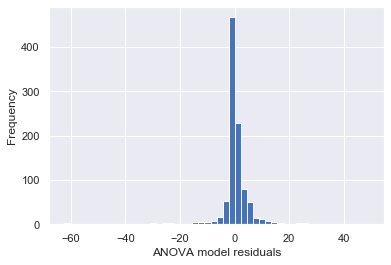

In [59]:
anova_model_residuals = (anova_df.difference_of_averages 
                         - model.predict().reshape(before_after.unstack().shape))
_ = plt.hist(anova_model_residuals, bins=50)
_ = plt.ylabel('Frequency')
_ = plt.xlabel('ANOVA model residuals')
plt.savefig('anova_residuals.jpg', bbox_inches='tight')

Next, look at the variances between the different mandates and countries.

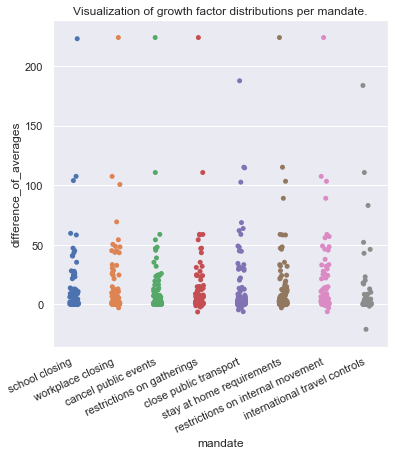

In [60]:
plt.figure(figsize=(6,6))
sns.stripplot(data=anova_df, x='mandate', y='difference_of_averages', s=5)
plt.xticks(rotation=25)
loc, _ = plt.xticks()
plt.xticks([0,1,2,3,4,5,6,7], government_responses_labels, ha='right')
plt.title('Visualization of growth factor distributions per mandate.')
plt.savefig('anova_variance_mandate.jpg', bbox_inches='tight')

I would say that the distributions corresponding to each mandate type have the same variance, but they do not look normally distributed. For the country-wise distributions, the variances are less obvious but since there are only 8 observations per country the interpretation isn't as simple as it might seem on the surface.

Let's just assume that the ANOVA results are valid; the p-values in the model summary already gave an indication as to which of the mandates are important, but let's supplement this with some more basic statistical analysis. First, compute the average effect with respect to each mandate type, larger values translate to a larger positive effect. Note that the two significant mandates from the model were public transport and international travel controls. It is probably intuitive to assume that these two should have the largest average effect, but I believe this is where the time dependence comes to play. International travel controls had the earliest average enaction date, i.e. when the pandemic was beginning. In other words, because the pandemic was beginning, the average number of new cases would typically be smaller, meaning that its significance is due to its relative effectiveness, not absolute.

In [61]:
before_after.mean(axis=0).sort_values(ascending=False)

c5_close_public_transport               11.989608
c7_restrictions_on_internal_movement    11.561318
c6_stay_at_home_requirements            11.417766
c2_workplace_closing                    11.275087
c1_school_closing                       10.085681
c4_restrictions_on_gatherings            9.891894
c3_cancel_public_events                  9.152495
c8_international_travel_controls         5.506708
dtype: float64

In [62]:
start_dates.mean(axis=0)

c1_school_closing                       52.483871
c2_workplace_closing                    58.403226
c3_cancel_public_events                 51.411290
c4_restrictions_on_gatherings           57.443548
c5_close_public_transport               62.758065
c6_stay_at_home_requirements            61.185484
c7_restrictions_on_internal_movement    60.080645
c8_international_travel_controls        31.564516
dtype: float64

The main issue with this entire analysis is the lack of independence between the mandates as well as the time dependence of the problem. Mandates which occur first may be more effective simply because of their timing. To compare this, let's look at the difference in case number averages when plotted against their enaction dates. 

In [63]:
day_of_infection = np.tile(response_slices_df.applymap(lambda x : x.start).active_pandemic_dates.values.reshape(-1,1),(1,8))
time_diff = (start_dates.values - day_of_infection)

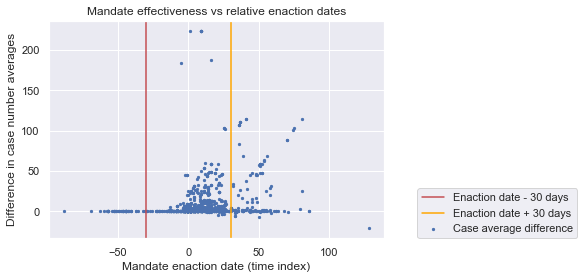

In [64]:
fig, ax = plt.subplots()
ax.scatter(time_diff.ravel(), before_after.values.ravel(), s=5, label='Case average difference')
ax.set_xlabel('Mandate enaction date (time index)')
ax.set_ylabel('Difference in case number averages')
ax.set_title('Mandate effectiveness vs relative enaction dates')
plt.axvline(-30, color='r', label='Enaction date - 30 days')
plt.axvline(30, color='orange', label='Enaction date + 30 days')
plt.legend(loc=(1.1,0.))
plt.savefig('case_avg_diff_relative_to_enaction_date.jpg', bbox_inches='tight')
plt.show()

This shows that the mandates enacted around the start of each epidemic have the most effect; but this is selection bias as of course mandates that occur before can't have any effect. This is my argument that my anova analysis should be taken with a grain of salt due to the lack of independence.

<a id='dependent'></a>
# 8. Dependent variable preview
[Return to table of contents](#toc)

The dependent variable to be predicted is the number of new cases per million.
There are a number of important tasks to complete before the modeling process, such as choosing the size of the time window, which dates to include, which countries to include, etc. The countries with populations less than 1000000 people have already been removed as very small populations such as The Vatican would be unfairly weighted otherwise. Since I mentioned The Vatican, let's compare its new cases per million people with the global average. 

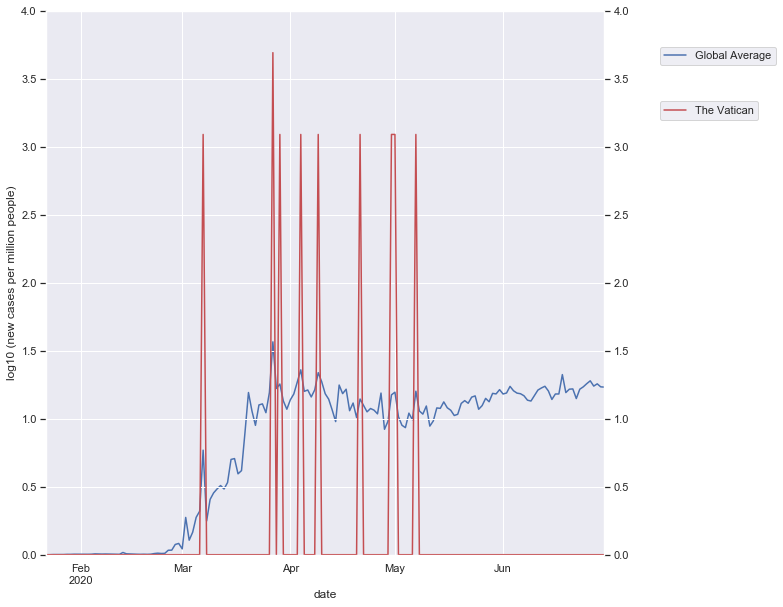

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
ax2 = ax.twinx()
data.groupby('date').new_cases_per_million_owid.mean().apply(lambda x : np.log10(x+1)).plot(ax=ax, label='Global Average')
data[data.location=='Vatican'].set_index('date').new_cases_per_million_owid.apply(lambda x : np.log10(x+1)).plot(ax=ax2, c='r', label='The Vatican')
ax.set_ylim([0,4])
ax2.set_ylim([0,4])
ax.set_ylabel('log10 (new cases per million people)')
ax.legend(loc=(1.1,0.9))
ax2.legend(loc=(1.1,0.8))
plt.savefig('ncpm.jpg', bbox_inches='tight')

Hopefully it can be seen that these two time series depicted above exhibit wildly different behavior. It's for this reason that the smallest countries are excluded. 

Let's look at how this affects the collection of time series, comparing the before and after this pruning of the set of countries. 

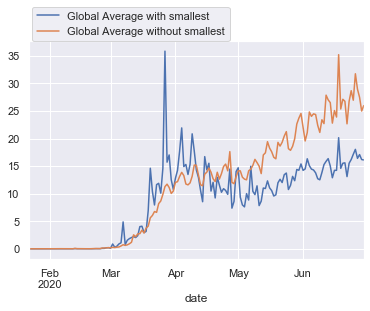

In [66]:
data.groupby('date').new_cases_per_million_owid.mean().plot(label='Global Average with smallest')
data[data.population_owid>1000000.].groupby('date').new_cases_per_million_owid.mean().plot(label='Global Average without smallest')
plt.legend(loc=(0.01,1.))

The average changes substantially because of the pruning of countries, but there will be fewer pathological time series like that of the Vatican's new cases per million. Let's look at the statistics and see if anything stands out.

In [67]:
data[data.location.isin(response_slices_df.index.tolist())].new_cases_per_million_owid.describe()

count    19964.000000
mean        12.196584
std         45.138277
min       -265.189000
25%          0.000000
50%          0.100000
75%          4.865000
max       1060.758000
Name: new_cases_per_million_owid, dtype: float64

The minimum is negative which is clearly an indication of errors in the data, as new cases cannot be negative. I fix errors like this as well as isolated zeros by replacing these values via forward filling. My justification is that the actual pandemic isn't stopping even if there is a lack of reporting. Therefore, I think my modfication makes the time series more "realistic". Note that if the small countries were included, this would drastically overestimate their new cases per million time series. So, the next step is to modify the time series and look at the new statistics.

In [68]:
modified_time_series = modify_time_series_zeros(data, 'new_cases_per_million_owid')
modified_time_series[modified_time_series.location.isin(response_slices_df.index.tolist())].new_cases_per_million_owid.describe()

count    19964.000000
mean        13.534590
std         48.093475
min          0.000000
25%          0.000000
50%          0.657000
75%          6.906000
max       1060.758000
Name: new_cases_per_million_owid, dtype: float64

There are no longer negative values and the other statistics have not changed dramatically. Lastly, plot the new global average time series.

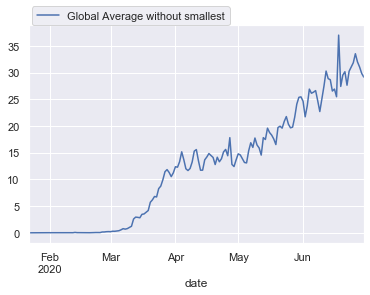

In [69]:
(modified_time_series[modified_time_series.population_owid>1000000.].groupby('date').new_cases_per_million_owid
).mean().plot(label='Global Average without smallest')
plt.legend(loc=(0.01,1.))

In summary for the modified time series, the time series for new cases per million people are modified to better represent an on-going pandemic without reporting errors, even though this does in fact change the time series which is something to consider for the modeling process.



<a id='summary'></a>
# 9. Summary 
[Return to table of contents](#toc)

The pandemic is worsening and so I believe more analysis is required into the effectiveness of social distancing measures. A very notably lacking piece of information is data on mask wearing. I suspect that the relationship between the pandemic and mask wearing would be dramatic. In the future I would like to find data which quantifies mask usage. The other summarizing point is that I am modifying the dependent variable's time series in exchange for much more continuous time series, looking ahead towards the application of neural networks which learn the features of said time series; especially the convolutional neural networks.